# Build, Train, and Deploy ML Pipelines using BERT

# Table of Contents

1. Configure the SageMaker Feature Store

    1.1. Configure dataset
    
    1.2. Configure the SageMaker feature store
    
2. Transform the dataset

3. Query the Feature Store

    3.1. Export training, validation, and test datasets from the Feature Store
    
    3.2. Export TSV from Feature Store
    
    3.3. Check that the dataset in the Feature Store is balanced by sentiment
    
4. Configure dataset, hyper-parameters and evaluation metrics

    4.1. Configure dataset
    
    4.2. Configure model hyper-parameters
    
    4.3. Setup evaluation metrics
    
    4.4. Setup Debugger and Profiler
    
5. Train model

    5.1. Setup the RoBERTa and PyTorch script to run on SageMaker
    
    5.2. Analyze Debugger results
    
    5.3. Download SageMaker debugger profiling report
    
6. Deploy the model

7. Test model

8. Configure the dataset and processing step of the pipeline

    8.1. Configure S3 path for raw input data
    
    8.2. Configure processing step
    
9. Configure training step of the pipeline

    9.1. Define parameters
    
    9.2. Configure hyper-parameters
    
    9.3. Configure model-evaluation metrics
    
    9.4. Configure the PyTorchEstimator
    
    9.5. Setup pipeline step caching
    
    9.6. Configure the TrainingStep
    
10. Configure model-evaluation step of the pipeline

11. Configure and register model step of the pipeline

    11.1. Configure the model for deployment
    
    11.2. Register the model for deployment
    
12. Create model for deployment step of the pipeline

13. Check accuracy condition step of the pipeline

14. Create pipeline

    14.1. Define a pipeline of parameters, steps, and conditions
    
    14.2. Start Pipeline
    
    14.3. Wait for pipeline execution
    
    14.4. Describe completed pipeline
    
    14.5. Wait for the pipeline to complete
    
15. Evaluate the model

    15.1. Describe evaluation metrics
    
    15.2. Review the evaluation report
    
    15.3. List pipeline artifacts
    
16. Deploy and test the model

    16.1. Approve trained model
    
    16.2. Deploy model
    
    16.3. Create endpoint from registry
    
    16.4. Test model
    
    16.5. SageMaker Studio extensions

# 1. Configure the SageMaker Feature Store

We will start with the raw Women's Clothing Reviews dataset and prepare it to train a BERT-based natural language processing (NLP) model. The model will be used to classify customer reviews into positive (1), neutral (0) and negative (-1) sentiment.

We will convert the original review text into machine-readable features used by BERT. To perform the required feature transformation we will configure an Amazon SageMaker processing job, which will be running a custom Python script.

In [3]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker
!conda install -q -y pytorch -c pytorch
!pip install --disable-pip-version-check -q transformers

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch


The following packages will be UPDATED:

  pytorch                                 1.6.0-py3.7_cpu_0 --> 1.12.0-py3.7_cpu_0


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


In [2]:
import boto3
import sagemaker
import botocore

In [3]:
config = botocore.config.Config(user_agent_extra='dlai-pds/c2/w1')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

featurestore_runtime = boto3.client(service_name='sagemaker-featurestore-runtime', 
                                    config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_featurestore_runtime_client=featurestore_runtime)

In [4]:
bucket = sess.default_bucket()

In [5]:
role = sagemaker.get_execution_role()
region = sess.boto_region_name

### 1.1. Configure dataset
The raw dataset is in the public S3 bucket. Let's start by specifying the S3 location of it:

In [6]:
raw_input_data_s3_uri = 's3://dlai-practical-data-science/data/raw/' #
print(raw_input_data_s3_uri)

s3://dlai-practical-data-science/data/raw/


List the files in the S3 bucket (in this case it will be just one file):

In [7]:
!aws s3 ls $raw_input_data_s3_uri

2021-04-30 02:21:06    8457214 womens_clothing_ecommerce_reviews.csv


### 1.2. Configure the SageMaker feature store

As the result of the transformation, in addition to generating files in S3 bucket, you will also save the transformed data in the Amazon SageMaker Feature Store to be used by others in your organization, for example.

To configure a Feature Store you need to setup a Feature Group. This is the main resource containing all of the metadata related to the data stored in the Feature Store. 
A Feature Group should contain a list of Feature Definitions. A Feature Definition consists of a name and the data type. 
The Feature Group also contains an online store configuration and an offline store configuration controlling where the data is stored. Enabling the online store allows quick access to the latest value for a record via the GetRecord API. The offline store allows storage of the data in your S3 bucket. 

We will be using the offline store.

Let's setup the Feature Group name and the Feature Store offline prefix in S3 bucket:

In [8]:
import time
timestamp = int(time.time())

feature_group_name = 'reviews-feature-group-' + str(timestamp)
feature_store_offline_prefix = 'reviews-feature-store-' + str(timestamp)

print('Feature group name: {}'.format(feature_group_name))
print('Feature store offline prefix in S3: {}'.format(feature_store_offline_prefix))

Feature group name: reviews-feature-group-1658777162
Feature store offline prefix in S3: reviews-feature-store-1658777162


Taking two features from the original raw dataset (Review Text and Rating), we will transform it preparing to be used for the model training and then to be saved in the Feature Store. Here we will define the related features to be stored as a list of FeatureDefinition.

In [9]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions= [
    # unique ID of the review
    FeatureDefinition(feature_name='review_id', feature_type=FeatureTypeEnum.STRING), 
    # ingestion timestamp
    FeatureDefinition(feature_name='date', feature_type=FeatureTypeEnum.STRING),
    # sentiment: -1 (negative), 0 (neutral) or 1 (positive). It will be found the Rating values (1, 2, 3, 4, 5)
    FeatureDefinition(feature_name='sentiment', feature_type=FeatureTypeEnum.STRING), 
    # label ID of the target class (sentiment)
    FeatureDefinition(feature_name='label_id', feature_type=FeatureTypeEnum.STRING),
    # reviews encoded with the BERT tokenizer
    FeatureDefinition(feature_name='input_ids', feature_type=FeatureTypeEnum.STRING),
    # original Review Text
    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING),
    # train/validation/test label
    FeatureDefinition(feature_name='split_type', feature_type=FeatureTypeEnum.STRING)
]

Create the feature group 

In [10]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(
    name=feature_group_name,
    feature_definitions=feature_definitions, 
    sagemaker_session=sess
)

print(feature_group)

FeatureGroup(name='reviews-feature-group-1658777162', sagemaker_session=<sagemaker.session.Session object at 0x7fa1634d83d0>, feature_definitions=[FeatureDefinition(feature_name='review_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='sentiment', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='label_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='review_body', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='split_type', feature_type=<FeatureTypeEnum.STRING: 'String'>)])


## 2. Transform the dataset

We will configure a SageMaker processing job to run a custom Python script to balance and transform the raw data into a format used by BERT model.

Set the transformation parameters including the instance type, instance count, and train/validation/test split percentages. For the purposes of this lab, we will use a relatively small instance type. 

We can also choose whether you want to balance the dataset or not. In this case, we will balance the dataset to avoid class imbalance in the target variable, sentiment.

Another important parameter of the model is the max_seq_length, which specifies the maximum length of the classified reviews for the RoBERTa model. If the sentence is shorter than the maximum length parameter, it will be padded. In another case, when the sentence is longer, it will be truncated from the right side.

Since a smaller max_seq_length leads to faster training and lower resource utilization, we want to find the smallest power-of-2 that captures 100% of our reviews. For this dataset, the 100th percentile is 115. However, it's best to stick with powers-of-2 when using BERT. So let's choose 128 as this is the smallest power-of-2 greater than 115. You will see below how the shorter sentences will be padded to a maximum length.

In [11]:
processing_instance_type='ml.c5.xlarge'
processing_instance_count=1
train_split_percentage=0.90
validation_split_percentage=0.05
test_split_percentage=0.05
balance_dataset=True
max_seq_length=128

In [12]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={'AWS_DEFAULT_REGION': region},                             
    max_runtime_in_seconds=7200
)

The processing job will be running the Python code from the file src/prepare_data.py.

In [13]:
import sys, importlib
sys.path.append('src/')

# import the `prepare_data.py` module
import prepare_data

# reload the module if it has been previously loaded 
if 'prepare_data' in sys.modules:
    importlib.reload(prepare_data)

input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)

##################
Updated correctly!
##################


Review the results of tokenization for the given example (\"this product is great!\"):

In [14]:
input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)

print(input_ids)
print('Length of the sequence: {}'.format(len(input_ids)))

[0, 9226, 1152, 16, 372, 328, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of the sequence: 128


Launch the processing job with the custom script passing defined above parameters.

In [15]:
from sagemaker.processing import ProcessingInput, ProcessingOutput


processor.run(code='src/prepare_data.py',
              inputs=[
                    ProcessingInput(source=raw_input_data_s3_uri,
                                    destination='/opt/ml/processing/input/data/',
                                    s3_data_distribution_type='ShardedByS3Key')
              ],
              outputs=[
                    ProcessingOutput(output_name='sentiment-train',
                                     source='/opt/ml/processing/output/sentiment/train',
                                     s3_upload_mode='EndOfJob'),
                    ProcessingOutput(output_name='sentiment-validation',
                                     source='/opt/ml/processing/output/sentiment/validation',
                                     s3_upload_mode='EndOfJob'),
                    ProcessingOutput(output_name='sentiment-test',
                                     source='/opt/ml/processing/output/sentiment/test',
                                     s3_upload_mode='EndOfJob')
              ],
              arguments=['--train-split-percentage', str(train_split_percentage),
                         '--validation-split-percentage', str(validation_split_percentage),
                         '--test-split-percentage', str(test_split_percentage),
                         '--balance-dataset', str(balance_dataset),
                         '--max-seq-length', str(max_seq_length),                         
                         '--feature-store-offline-prefix', str(feature_store_offline_prefix),
                         '--feature-group-name', str(feature_group_name)                         
              ],
              logs=True,
              wait=False)



Job Name:  sagemaker-scikit-learn-2022-07-25-19-28-50-882
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://dlai-practical-data-science/data/raw/', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/input/code/prepare_data.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'sentiment-train', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/output/sentiment-train', 'LocalPath': '/opt/ml/processing/output/sentiment/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputNa

You can see the information about the processing jobs using the describe function. The result is in dictionary format. Let's pull the processing job name:

In [16]:
scikit_processing_job_name = processor.jobs[-1].describe()['ProcessingJobName']

print('Processing job name: {}'.format(scikit_processing_job_name))

Processing job name: sagemaker-scikit-learn-2022-07-25-19-28-50-882


Pull the processing job status from the processing job description.

In [17]:
print(processor.jobs[-1].describe().keys())

dict_keys(['ProcessingInputs', 'ProcessingOutputConfig', 'ProcessingJobName', 'ProcessingResources', 'StoppingCondition', 'AppSpecification', 'Environment', 'RoleArn', 'ProcessingJobArn', 'ProcessingJobStatus', 'LastModifiedTime', 'CreationTime', 'ResponseMetadata'])


In [18]:
scikit_processing_job_status = processor.jobs[-1].describe()['ProcessingJobStatus']
print('Processing job status: {}'.format(scikit_processing_job_status))

Processing job status: InProgress


To review the created processing job in the AWS console:
+ open the link
+ notice that you are in the section Amazon SageMaker -> Processing jobs
+ check the name of the processing job, its status and other available information

In [19]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, scikit_processing_job_name)))

Wait for about 5 minutes to review the CloudWatch Logs. You may open the file src/prepare_data.py again and examine the outputs of the code in the CloudWatch logs.

In [20]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, scikit_processing_job_name)))

After the completion of the processing job you can also review the output in the S3 bucket.

In [21]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 output data</a> after the processing job has completed</b>'.format(bucket, scikit_processing_job_name, region)))

Wait for the processing job to complete.

This cell will take approximately 15 minutes to run.

In [22]:
%%time

running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name,
    sagemaker_session=sess
)

running_processor.wait(logs=False)

......................................................................................................................................................................!CPU times: user 638 ms, sys: 80.2 ms, total: 718 ms
Wall time: 13min 54s


Please wait until ^^ Processing Job ^^ completes above

Inspect the transformed and balanced data in the S3 bucket.

In [23]:
processing_job_description = running_processor.describe()

output_config = processing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'sentiment-train':
        processed_train_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-validation':
        processed_validation_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-test':
        processed_test_data_s3_uri = output['S3Output']['S3Uri']
        
print(processed_train_data_s3_uri)
print(processed_validation_data_s3_uri)
print(processed_test_data_s3_uri)

s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/output/sentiment-train
s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/output/sentiment-validation
s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/output/sentiment-test


In [24]:
!aws s3 ls $processed_train_data_s3_uri/

2022-07-25 19:42:45    4875880 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [25]:
!aws s3 ls $processed_validation_data_s3_uri/

2022-07-25 19:42:45     268096 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [26]:
!aws s3 ls $processed_test_data_s3_uri/

2022-07-25 19:42:45     277939 part-algo-1-womens_clothing_ecommerce_reviews.tsv


Copy the data into the folder balanced.

In [27]:
!aws s3 cp $processed_train_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-train/
!aws s3 cp $processed_validation_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-validation/
!aws s3 cp $processed_test_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./balanced/sentiment-test/

download: s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/output/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/output/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-19-28-50-882/output/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv to balanced/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv


Review the training, validation and test data outputs:

In [28]:
!head -n 5 ./balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
5644	1	2	[0, 4528, 5909, 32, 55, 3473, 87, 14711, 33609, 4, 51, 32, 2299, 22, 5982, 3631, 196, 113, 8, 356, 10, 410, 3298, 571, 906, 15, 87, 11, 5, 1345, 1437, 53, 202, 11962, 8, 34203, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	"These literally are more comfortable than sweatpants. they are definitely ""relaxed"" and look a little baggier on than in the photo  but still cute and flattering."	2022-07-25T19:37:16Z
6562	-1	0	[0, 100, 657, 13855, 27734, 13, 49, 2496, 8, 5863, 4, 939, 2638, 5, 356, 9, 42, 2440, 11052, 4122, 2125, 1437, 8, 5, 1551, 14, 26, 24, 21, 101, 18437, 3568, 47, 115, 3568, 66, 9, 5, 790, 4, 939, 2854, 14, 24, 16, 101, 18437, 3568, 1437, 53, 13, 162, 1437, 89, 58, 10, 367, 2019, 4, 14

In [29]:
!head -n 5 ./balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
2723	1	2	[0, 33239, 12, 8287, 33391, 328, 939, 3568, 42, 19, 14442, 23, 5, 558, 1437, 8, 21288, 15, 5, 12729, 12, 2422, 16106, 4, 1437, 42, 16, 65, 9, 167, 3745, 14, 47, 489, 6000, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	Non-stop compliments! i wear this with dresses at the office  and denim on the weekends- super versatile.  this is one of those pieces that you keep forever.	2022-07-25T19:37:16Z
17510	-1	0	[0, 713, 399, 75, 173, 13, 162, 4, 1437, 5, 2125, 1415, 6162, 1437, 12783, 182, 239, 734, 14546, 7, 28, 1181, 4, 1437, 5, 2125, 1326, 20044, 13, 103, 1219, 7, 127, 2473, 4, 1437, 24, 67, 473, 45, 2045, 1318, 13, 41, 6215, 2125, 4, 1437, 42, 439, 124, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [30]:
!head -n 5 ./balanced/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
8926	0	1	[0, 100, 2740, 127, 2340, 1836, 11, 42, 3588, 4, 939, 524, 231, 2767, 6764, 1437, 53, 5, 1675, 10070, 58, 350, 739, 8, 350, 251, 36, 16079, 12, 438, 10595, 322, 939, 1835, 5, 3588, 13, 10, 1836, 2735, 11, 4716, 1459, 13, 10, 55, 34203, 23385, 1902, 4, 5, 3588, 16, 9869, 1437, 941, 15, 5, 3092, 11, 5, 3493, 1437, 53, 399, 75, 1341, 173, 66, 13, 162, 4, 67, 1437, 24, 2653, 101, 89, 32, 2213, 9, 6803, 31991, 14, 146, 2057, 15, 73, 16883, 160, 5, 3588, 2045, 7, 185, 41, 16616, 251, 86, 328, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	I ordered my normal size in this dress. i am 6 foot tall  but the regular sizes were too large and too long (mid-calf). i returned the dress for a size smaller in petite for a more flattering hemline. the dress is lovely  especially on the models in the pictures  but didn't quite work out for me. also  it feels like there are hundreds of closure hooks that 

## 3. Query the Feature Store

In addition to transforming the data and saving in S3 bucket, the processing job populates the feature store with the transformed and balanced data. Let's query this data using Amazon Athena.


### 3.1. Export training, validation, and test datasets from the Feature Store
Here you will do the export only for the training dataset, as an example.

Use athena_query() function to create an Athena query for the defined above Feature Group. Then you can pull the table name of the Amazon Glue Data Catalog table which is auto-generated by Feature Store.

In [31]:
feature_store_query = feature_group.athena_query()

feature_store_table = feature_store_query.table_name

query_string = """
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "{}" 
    WHERE split_type='train' 
    LIMIT 5
""".format(feature_store_table)

print('Glue Catalog table name: {}'.format(feature_store_table))
print('Running query: {}'.format(query_string))

Glue Catalog table name: reviews-feature-group-1658777162-1658777806
Running query: 
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "reviews-feature-group-1658777162-1658777806" 
    WHERE split_type='train' 
    LIMIT 5



Configure the S3 location for the query results. This allows us to re-use the query results for future queries if the data has not changed. We can even share this S3 location between team members to improve query performance for common queries on data that does not change often.

In [32]:
output_s3_uri = 's3://{}/query_results/{}/'.format(bucket, feature_store_offline_prefix)
print(output_s3_uri)

s3://sagemaker-us-east-1-310167366207/query_results/reviews-feature-store-1658777162/


Query the feature store.

In [33]:
feature_store_query.run(
    query_string=query_string, 
    output_location=output_s3_uri 
)

feature_store_query.wait()

In [34]:
import pandas as pd
pd.set_option("max_colwidth", 100)

df_feature_store = feature_store_query.as_dataframe()
df_feature_store

,date,review_id,sentiment,label_id,input_ids,review_body
0,2022-07-25T19:37:16Z,3550,0,1,"[0, 713, 16, 10, 2721, 3588, 4, 939, 23855, 62, 132, 10070, 716, 15, 97, 6173, 8, 24, 10698, 157...",This is a beautiful dress. i sized up 2 sizes based on other reviews and it fits well. it is on ...
1,2022-07-25T19:37:16Z,634,-1,0,"[0, 100, 21, 98, 2283, 7, 645, 42, 23204, 53, 21, 98, 5779, 77, 24, 376, 4, 5, 29716, 16, 5568, ...",I was so excited to order this sweater but was so disappointed when it came. the knit is somewha...
2,2022-07-25T19:37:16Z,12635,-1,0,"[0, 100, 269, 770, 7, 657, 42, 299, 1437, 53, 89, 16, 169, 350, 203, 10199, 4, 24, 1326, 1085, 1...",I really wanted to love this top but there is way too much fabric. it looks nothing like the pi...
3,2022-07-25T19:37:16Z,673,1,2,"[0, 100, 2162, 42, 11, 909, 8, 24, 222, 2703, 162, 7, 3568, 10, 6399, 12213, 25, 24, 21, 10, 410...",I bought this in black and it did require me to wear a shirt underneath as it was a little sheer...
4,2022-07-25T19:37:16Z,14227,-1,0,"[0, 100, 2740, 10, 739, 8, 1135, 2498, 10, 739, 11, 171, 97, 1964, 31, 9876, 338, 9547, 8982, 32...",I ordered a large and despite wearing a large in many other items from antrhopologie this item ...


Review the Feature Store in SageMaker Studio

## 3.2. Export TSV from Feature Store

Save the output as a TSV file:

In [35]:
df_feature_store.to_csv('./feature_store_export.tsv',
                        sep='\t',
                        index=False,
                        header=True)

In [36]:
!head -n 5 ./feature_store_export.tsv

date	review_id	sentiment	label_id	input_ids	review_body
2022-07-25T19:37:16Z	3550	0	1	[0, 713, 16, 10, 2721, 3588, 4, 939, 23855, 62, 132, 10070, 716, 15, 97, 6173, 8, 24, 10698, 157, 4, 24, 16, 15, 5, 10941, 526, 4, 939, 3584, 5, 2440, 8, 24, 18, 10, 2721, 3195, 4, 939, 21, 11, 657, 19, 5, 3588, 454, 5, 43805, 10084, 490, 71, 2498, 24, 13, 292, 728, 4, 939, 206, 939, 437, 164, 7, 33, 5, 43805, 4209, 142, 939, 101, 24, 98, 203, 4, 53, 23, 5, 239, 425, 477, 89, 197, 28, 10, 12628, 43805, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	This is a beautiful dress. i sized up 2 sizes based on other reviews and it fits well. it is on the shorter side. i purchased the blue and it's a beautiful color. i was in love with the dress until the zipper burst open after wearing it for five minutes. i think i'm going to have the zipper replaced because i like it so much. but at the high price point there should be a functional 

Upload TSV to the S3 bucket:

In [37]:
!aws s3 cp ./feature_store_export.tsv s3://$bucket/feature_store/feature_store_export.tsv

upload: ./feature_store_export.tsv to s3://sagemaker-us-east-1-310167366207/feature_store/feature_store_export.tsv


Check the file in the S3 bucket:

In [38]:
!aws s3 ls --recursive s3://$bucket/feature_store/feature_store_export.tsv

2022-07-25 19:58:19       4010 feature_store/feature_store_export.tsv


### 3.3. Check that the dataset in the Feature Store is balanced by sentiment

Now you can setup an Athena query to check that the stored dataset is balanced by the target class sentiment.
Write an SQL query to count the total number of the reviews per sentiment stored in the Feature Group.

In [39]:
feature_store_query_2 = feature_group.athena_query()
query_string_count_by_sentiment = """
SELECT sentiment, COUNT(*) AS count_reviews
FROM "{}"
GROUP BY sentiment
""".format(feature_store_table)

Query the feature store.

In [40]:
feature_store_query_2.run(
    query_string=query_string_count_by_sentiment, 
    output_location=output_s3_uri 
)

feature_store_query_2.wait()

df_count_by_sentiment = feature_store_query_2.as_dataframe()
df_count_by_sentiment

,sentiment,count_reviews
0,1,2051
1,-1,2051
2,0,2051


Visualize the result of the query in the bar plot, showing the count of the reviews by sentiment value.

In [41]:
import seaborn as sns

sns.barplot(
    data=df_count_by_sentiment, 
    x='sentiment', 
    y='count_reviews', 
    color="blue"
)


## 4. Configure dataset, hyper-parameters and evaluation metrics

Now we will train a text classifier using a variant of BERT called RoBERTa - a Robustly Optimized BERT Pretraining Approach - within a PyTorch model ran as a SageMaker Training Job.
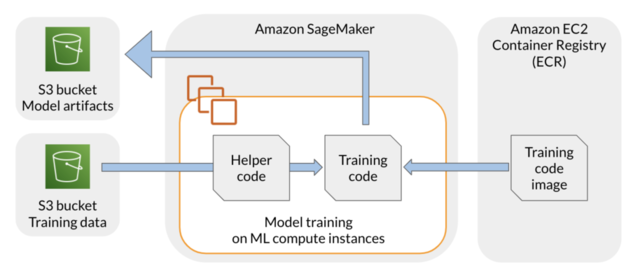

In [42]:
# !pip install sagemaker
# !conda install pytorch --y
# !pip install transformers

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

### 4.1. Configure dataset

You have already transformed and balanced the data into a format that the model expects. Let's copy this data to S3. You will be using training and validation datasets to train the model. Test dataset will be used for tuning later. Setup the paths:

In [44]:
processed_train_data_s3_uri = 's3://{}/data/sentiment-train/'.format(bucket)
processed_validation_data_s3_uri = 's3://{}/data/sentiment-validation/'.format(bucket)

Upload the data to S3 bucket:

In [45]:
!aws s3 cp --recursive ./balanced/sentiment-train $processed_train_data_s3_uri
!aws s3 cp --recursive ./balanced/sentiment-validation $processed_validation_data_s3_uri

upload: balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv to s3://sagemaker-us-east-1-310167366207/data/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv
upload: balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv to s3://sagemaker-us-east-1-310167366207/data/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv


Check the existence of those files in the S3 bucket:

In [46]:
!aws s3 ls --recursive $processed_train_data_s3_uri

2022-07-25 19:58:33    4875880 data/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [47]:
!aws s3 ls --recursive $processed_validation_data_s3_uri

2022-07-25 19:58:33     268096 data/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv


We will need to setup the input data channels, wrapping the S3 locations in a TrainingInput object to use with the SageMaker Training Job. This can be organized as a dictionary

data_channels = {

    'train': ..., # training data
    
    'validation': ... # validation data
    
}

where training and validation data are the Amazon SageMaker channels for S3 input data sources.

In [48]:
s3_input_train_data = sagemaker.inputs.TrainingInput(
    s3_data=processed_train_data_s3_uri 
)

In [49]:
s3_input_validation_data = sagemaker.inputs.TrainingInput(
    s3_data=processed_validation_data_s3_uri 
)

In [50]:
data_channels = {
    'train': s3_input_train_data, 
    'validation': s3_input_validation_data 
}

### 4.2. Configure model hyper-parameters
Set the Training Job parameters including the instance type, instance count, learning rate, batch size etc. 

For the purposes of this experiment, we will use a relatively small instance type.

In [51]:
max_seq_length=128 # maximum number of input tokens passed to BERT model
freeze_bert_layer=False # specifies the depth of training within the network
epochs=3
learning_rate=2e-5
train_batch_size=256
train_steps_per_epoch=50
validation_batch_size=256
validation_steps_per_epoch=50
seed=42
run_validation=True

train_instance_count=1
train_instance_type='ml.c5.9xlarge'
train_volume_size=256
input_mode='File'

Some of them will be passed into the PyTorch estimator in the hyperparameters argument. Let's setup the dictionary for that:

In [52]:
hyperparameters={
    'max_seq_length': max_seq_length,
    'freeze_bert_layer': freeze_bert_layer,
    'epochs': epochs,
    'learning_rate': learning_rate,
    'train_batch_size': train_batch_size,
    'train_steps_per_epoch': train_steps_per_epoch,
    'validation_batch_size': validation_batch_size,
    'validation_steps_per_epoch': validation_steps_per_epoch,    
    'seed': seed,
    'run_validation': run_validation
}

### 4.3. Setup evaluation metrics

Choose loss and accuracy as the evaluation metrics. The regular expressions Regex will capture the values of metrics that the algorithm will emit.

In [53]:
metric_definitions = [
     {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9.]+)'},
     {'Name': 'validation:accuracy', 'Regex': 'val_acc: ([0-9.]+)'},
]

### 4.4. Setup Debugger and Profiler

Amazon SageMaker Debugger can be used to profile machine learning models, helping to identify and fix training issues caused by hardware resource usage. Setting some parameters in the SageMaker estimator, without any change to the training code, you can enable the collection of infrastructure and model metrics such as: CPU and GPU, RAM and GPU RAM, data loading time, time spent in ML operators running on CPU and GPU, distributed training metrics and many more. In addition, you can visualize how much time is spent in different phases, such as preprocessing, training loop, and postprocessing. If needed, you can drill down on each training epoch, and even on each function in your training script.

Define Debugger Rules as described here: https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html

In [54]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

DebuggerHookConfig provides options to customize how debugging information is emitted and saved. s3_output_path argument value defines the location in Amazon S3 to store the output.

In [55]:
debugger_hook_config = DebuggerHookConfig(
    s3_output_path='s3://{}'.format(bucket),
)

ProfilerConfig sets the configuration for collecting system and framework metrics of SageMaker Training Jobs. Parameter system_monitor_interval_millis sets the time interval to collect system metrics (in milliseconds). Parameter framework_profile_params is the object for framework metrics profiling. Here you will set its local path, the step at which to start profiling, start_step, and the number of steps to profile, num_steps.

In [56]:
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10)
)

For monitoring and profiling the built-in rules you can use the ProfilerReport. It creates a profiling report and updates when the individual rules are triggered. If you trigger this ProfilerReport rule without any customized parameter as in the cell below, then the ProfilerReport rule triggers all of the built-in rules for monitoring and profiling with their default parameter values.

The profiling report can be downloaded while the Training Job is running or after the job has finished.

In [57]:
rules=[ProfilerRule.sagemaker(rule_configs.ProfilerReport())]

## 5. Train model

### 5.1. Setup the RoBERTa and PyTorch script to run on SageMaker

We will prepare the PyTorch model to run as a SageMaker Training Job in a separate Python file, which will be called during the training.

Here we will be using the pre-trained model roberta-base. The information about the available models can be found in the Hugging Face website: https://huggingface.co/models

In [58]:
import sys, importlib
sys.path.append('src/')

import train

# reload the module if it has been previously loaded
if 'train' in sys.modules:
    importlib.reload(train)

# Ignore warnings below
config = train.configure_model()

label_0 = config.id2label[0]
label_1 = config.id2label[1]
label_2 = config.id2label[2]

##################
Updated correctly!
##################


Setup the PyTorch estimator to train our model. 

In [59]:
from sagemaker.pytorch import PyTorch as PyTorchEstimator

if updated_correctly:
    estimator = PyTorchEstimator(
        entry_point='train.py',
        source_dir='src',
        role=role,
        instance_count=train_instance_count,
        instance_type=train_instance_type,
        volume_size=train_volume_size,
        py_version='py3', # dynamically retrieves the correct training image (Python 3)
        framework_version='1.6.0', # dynamically retrieves the correct training image (PyTorch)
        hyperparameters=hyperparameters,
        metric_definitions=metric_definitions,
        input_mode=input_mode,
        debugger_hook_config=debugger_hook_config,
        profiler_config=profiler_config,
        rules=rules
    )

Launch the SageMaker Training Job which will be fitting the model to the dataset.

In [60]:
estimator.fit(
    inputs=data_channels, 
    wait=False
)

We can refer to the last Training Job using the estimator function latest_training_job. Then the Training Job name can be found with the name function:

In [61]:
training_job_name = estimator.latest_training_job.name

print('Training Job name: {}'.format(training_job_name))

Training Job name: pytorch-training-2022-07-25-19-58-49-821


We can also load the information about the Training Job using the function describe(). The result is in dictionary format. Let's check that it has the same Training Job name:

In [62]:
training_job_name = estimator.latest_training_job.describe()['TrainingJobName']

print('Training Job name: {}'.format(training_job_name))

Training Job name: pytorch-training-2022-07-25-19-58-49-821


Pull the Training Job status from the Training Job description:

In [63]:
print(estimator.latest_training_job.describe().keys())

dict_keys(['TrainingJobName', 'TrainingJobArn', 'TrainingJobStatus', 'SecondaryStatus', 'HyperParameters', 'AlgorithmSpecification', 'RoleArn', 'InputDataConfig', 'OutputDataConfig', 'ResourceConfig', 'StoppingCondition', 'CreationTime', 'LastModifiedTime', 'SecondaryStatusTransitions', 'EnableNetworkIsolation', 'EnableInterContainerTrafficEncryption', 'EnableManagedSpotTraining', 'DebugHookConfig', 'ProfilerConfig', 'ProfilerRuleConfigurations', 'ProfilerRuleEvaluationStatuses', 'ProfilingStatus', 'ResponseMetadata'])


In [64]:
training_job_status_primary = estimator.latest_training_job.describe()['TrainingJobStatus'] 
print('Training Job status: {}'.format(training_job_status_primary))

Training Job status: InProgress


Review the Training Job in the console:

In [65]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a></b>'.format(region, training_job_name)))

Review the Cloud Watch logs (after about 5 minutes):

In [66]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, training_job_name)))

In [67]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 output data</a> after the Training Job has completed</b>'.format(bucket, training_job_name, region)))

Wait for the Training Job to complete.

This cell will take approximately 30-40 minutes to run.

In [68]:
%%time

estimator.latest_training_job.wait(logs=False)


2022-07-25 20:48:26 Starting - Preparing the instances for training
2022-07-25 20:48:26 Downloading - Downloading input data
2022-07-25 20:48:26 Training - Training image download completed. Training in progress.
2022-07-25 20:48:26 Uploading - Uploading generated training model
2022-07-25 20:48:26 Completed - Training job completed
CPU times: user 20.8 ms, sys: 0 ns, total: 20.8 ms
Wall time: 73 ms


Wait until the ^^ Training Job ^^ completes above

Review the training metrics.

In [69]:
df_metrics = estimator.training_job_analytics.dataframe()
df_metrics

,timestamp,metric_name,value
0,0.0,validation:loss,1.09
1,1440.0,validation:loss,1.04
2,2040.0,validation:loss,0.62
3,0.0,validation:accuracy,34.77
4,1440.0,validation:accuracy,50.78
5,2040.0,validation:accuracy,72.27


You can query and plot the training metrics:

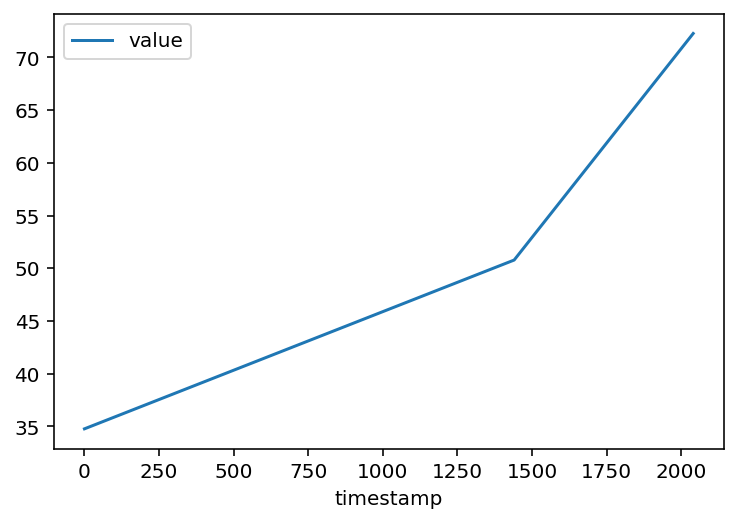

In [70]:
df_metrics.query("metric_name=='validation:accuracy'").plot(x='timestamp', y='value')

### 5.2. Analyze Debugger results

You can now explore the debugger output data:

In [71]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?prefix={}/">S3 debugger output data</a></b>'.format(
            bucket, training_job_name
        )
    )
)

### 5.3. Download SageMaker debugger profiling report
You can download and review the debugger profiling report. Here is the path in the S3 bucket:

In [72]:
profiler_report_s3_uri = "s3://{}/{}/rule-output/ProfilerReport/profiler-output".format(bucket, training_job_name)

You can list the report files:

In [73]:
!aws s3 ls $profiler_report_s3_uri/

                           PRE profiler-reports/
2022-07-25 20:45:06     364546 profiler-report.html
2022-07-25 20:45:06     211601 profiler-report.ipynb


The folder profiler-reports contains the built-in rule analysis components, stored in JSON and a Jupyter notebook. They are aggregated into the report.

In [74]:
!aws s3 cp --recursive $profiler_report_s3_uri ./profiler_report/

download: s3://sagemaker-us-east-1-310167366207/pytorch-training-2022-07-25-19-58-49-821/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to profiler_report/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-310167366207/pytorch-training-2022-07-25-19-58-49-821/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to profiler_report/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-310167366207/pytorch-training-2022-07-25-19-58-49-821/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to profiler_report/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-310167366207/pytorch-training-2022-07-25-19-58-49-821/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to profiler_report/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-310167366207/pytorch-training-2022-07-25-19-58-49-821/rul

You can review the profiler report in the console.

Note: Click Trust HTML in the profiler-report.html tab that opens (on top of the document).

In [75]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./profiler_report/profiler-report.html">profiler report</a></b>'))

## 6. Deploy the model

Create a custom SentimentPredictor that encapsulates a JSONLines serializer and deserializer. To be passed into the PyTorchModel it needs to be wrapped as a class.

In [76]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

class SentimentPredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super().__init__(endpoint_name, 
                         sagemaker_session=sagemaker_session, 
                         serializer=JSONLinesSerializer(),
                         deserializer=JSONLinesDeserializer())

In [77]:
import time
from sagemaker.pytorch.model import PyTorchModel

timestamp = int(time.time())

pytorch_model_name = '{}-{}-{}'.format(training_job_name, 'pt', timestamp)

model = PyTorchModel(name=pytorch_model_name,
                     model_data=estimator.model_data,
                     predictor_cls=SentimentPredictor,
                     entry_point='inference.py',
                     source_dir='src',
                     framework_version='1.6.0',
                     py_version='py3',
                     role=role)

In [78]:
import time

pytorch_endpoint_name = '{}-{}-{}'.format(training_job_name, 'pt', timestamp)

print(pytorch_endpoint_name)

pytorch-training-2022-07-25-19-58-49-821-pt-1658783079


This cell will take approximately 5-10 minutes to run.

In [79]:
%%time

predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.large', endpoint_name=pytorch_endpoint_name)

----------!CPU times: user 2min 15s, sys: 9.87 s, total: 2min 24s
Wall time: 7min 22s


Review the Endpoint in the AWS console.

Instructions:

open the link
notice that you are in the section Amazon SageMaker -> Endpoints
check the name of the Endpoint, its status and other available information

In [80]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST Endpoint</a></b>'.format(region, pytorch_endpoint_name)))

## 7. Test model
Here, we will pass sample strings of text to the endpoint in order to see the sentiment. We give you one example of each, however, feel free to play around and change the strings yourself!

In [81]:
inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = SentimentPredictor(endpoint_name=pytorch_endpoint_name,
                               sagemaker_session=sess)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

Predicted class 1 with probability 0.9557810425758362
Predicted class 0 with probability 0.6074870228767395
Predicted class -1 with probability 0.6791650652885437


Upload the notebook and train.py file into S3 bucket for grading purposes.

Note: you may need to save the file before the upload.

In [82]:
!aws s3 cp ./C2_W2_Assignment.ipynb s3://$bucket/C2_W2_Assignment_Learner.ipynb
!aws s3 cp ./src/train.py s3://$bucket/src/C2_W2_train_Learner.py


The user-provided path ./C2_W2_Assignment.ipynb does not exist.
upload: src/train.py to s3://sagemaker-us-east-1-310167366207/src/C2_W2_train_Learner.py


Now, we will do the following:

+ Define and run a pipeline using a directed acyclic graph (DAG) with specific pipeline parameters and model hyper-parameters
+ Define a processing step that cleans, balances, transforms, and splits our dataset into train, validation, and test dataset
+ Define a training step that trains a model using the train and validation datasets
+ Define a processing step that evaluates the trained model's performance on the test dataset
+ Define a register model step that creates a model package from the trained model
+ Define a conditional step that checks the model's performance and conditionally registers the model for deployment

In [83]:
import os
import sagemaker
import logging
import boto3
import sagemaker
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError

import time
timestamp = int(time.time())

pipeline_name = 'BERT-pipeline-{}'.format(timestamp)

# Pipeline

## 1. Configure the dataset and processing step

## 1.1. Configure S3 path for raw input data
The raw dataset is in the public S3 bucket. Let's start by specifying the S3 location of it:

In [84]:
raw_input_data_s3_uri = 's3://dlai-practical-data-science/data/raw/'
print(raw_input_data_s3_uri)

s3://dlai-practical-data-science/data/raw/


In [85]:
!aws s3 ls $raw_input_data_s3_uri

2021-04-30 02:21:06    8457214 womens_clothing_ecommerce_reviews.csv


## 1.2. Configure processing step
For the pipeline workflow you will need to create workflow parameters of a specific type: integer, string, or float.

In [86]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

Now set the parameters for the processing step.

In [87]:
processing_instance_type = ParameterString(
    name="ProcessingInstanceType",
    default_value="ml.c5.2xlarge"
)

processing_instance_count = ParameterInteger(
    name="ProcessingInstanceCount",
    default_value=1
)

train_split_percentage = ParameterFloat(
    name="TrainSplitPercentage",
    default_value=0.90,
)

validation_split_percentage = ParameterFloat(
    name="ValidationSplitPercentage",
    default_value=0.05,
)

test_split_percentage = ParameterFloat(
    name="TestSplitPercentage",
    default_value=0.05,
)

balance_dataset = ParameterString(
    name="BalanceDataset",
    default_value="True",
)

max_seq_length = ParameterInteger(
    name="MaxSeqLength",
    default_value=128,
)

feature_store_offline_prefix = ParameterString(
    name="FeatureStoreOfflinePrefix",
    default_value="reviews-feature-store-" + str(timestamp),
)

feature_group_name = ParameterString(
    name="FeatureGroupName",
    default_value="reviews-feature-group-" + str(timestamp)
)

input_data = ParameterString(
    name="InputData",
    default_value=raw_input_data_s3_uri,
)

Setting up scikit-learn-based processor, pass the SageMaker execution role, processing instance type and instance count.

In [88]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={'AWS_DEFAULT_REGION': region},                             
)

Now you will use the processor instance to construct a ProcessingStep, along with the input and output channels and the code that will be executed when the pipeline invokes pipeline execution. This is very similar to a processor instance's run method, for those familiar with the existing Python SDK.

Note the "sentiment-train", "sentiment-validation" and "sentiment-test" named channels specified in the output configuration for the processing job. Such step Properties can be used in subsequent steps and will resolve to their runtime values at execution. In particular, you will call out this usage defining the training step.

In [89]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

processing_inputs=[
    ProcessingInput(
        input_name='raw-input-data',
        source=input_data,
        destination='/opt/ml/processing/input/data/',
        s3_data_distribution_type='ShardedByS3Key'
    )
]

processing_outputs=[
    ProcessingOutput(output_name='sentiment-train',
                     source='/opt/ml/processing/output/sentiment/train',
                     s3_upload_mode='EndOfJob'),
    ProcessingOutput(output_name='sentiment-validation',
                     source='/opt/ml/processing/output/sentiment/validation',
                     s3_upload_mode='EndOfJob'),
    ProcessingOutput(output_name='sentiment-test',
                     source='/opt/ml/processing/output/sentiment/test',
                     s3_upload_mode='EndOfJob')
]        

processing_step = ProcessingStep(
    name='Processing', 
    code='src/prepare_data.py',
    processor=processor,
    inputs=processing_inputs,
    outputs=processing_outputs,
    job_arguments=['--train-split-percentage', str(train_split_percentage.default_value),                   
                   '--validation-split-percentage', str(validation_split_percentage.default_value),
                   '--test-split-percentage', str(test_split_percentage.default_value),
                   '--balance-dataset', str(balance_dataset.default_value),
                   '--max-seq-length', str(max_seq_length.default_value),                   
                   '--feature-store-offline-prefix', str(feature_store_offline_prefix.default_value),
                   '--feature-group-name', str(feature_group_name.default_value)
                  ]
)        

print(processing_step)

ProcessingStep(name='Processing', step_type=<StepTypeEnum.PROCESSING: 'Processing'>)


Now you can call out the properties of the processing job as an object using the command processing_step.properties. To print out and explore the attributes use __dict__ method.

In [90]:
# print out the list of the processing job properties
print(json.dumps(
    processing_step.properties.__dict__,
    indent=4, sort_keys=True, default=str
))

{
    "AppSpecification": "<sagemaker.workflow.properties.Properties object at 0x7fa1490f0e10>",
    "AutoMLJobArn": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd5e10>",
    "CreationTime": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd53d0>",
    "Environment": "<sagemaker.workflow.properties.Properties object at 0x7fa1490f00d0>",
    "ExitMessage": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd5110>",
    "ExperimentConfig": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd5490>",
    "FailureReason": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd5b90>",
    "LastModifiedTime": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd5f90>",
    "MonitoringScheduleArn": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd5fd0>",
    "NetworkConfig": "<sagemaker.workflow.properties.Properties object at 0x7fa148fd5990>",
    "ProcessingEndTime": "<sagemaker.workflow.properties.Properties

Pull the channel sentiment-train from the output configuration of the processing job. Print out the attributes of the resulting object:

In [91]:
print(json.dumps(
    processing_step.properties.ProcessingOutputConfig.Outputs['sentiment-train'].__dict__, 
    indent=4, sort_keys=True, default=str
))

{
    "AppManaged": "<sagemaker.workflow.properties.Properties object at 0x7fa162950e50>",
    "FeatureStoreOutput": "<sagemaker.workflow.properties.Properties object at 0x7fa16267d2d0>",
    "OutputName": "<sagemaker.workflow.properties.Properties object at 0x7fa16267d690>",
    "S3Output": "<sagemaker.workflow.properties.Properties object at 0x7fa16267d5d0>",
    "_path": "Steps.Processing.ProcessingOutputConfig.Outputs['sentiment-train']",
    "_shape_name": "ProcessingOutput"
}


Now you can pull and print out attributes of the S3 output path related to the sentiment-train output channel:

In [92]:
print(json.dumps(
    processing_step.properties.ProcessingOutputConfig.Outputs['sentiment-train'].S3Output.S3Uri.__dict__,
    indent=4, sort_keys=True, default=str
))

{
    "__str__": "S3Uri",
    "_path": "Steps.Processing.ProcessingOutputConfig.Outputs['sentiment-train'].S3Output.S3Uri",
    "_shape_name": "S3Uri"
}


Pull and print out attributes of the S3 output path object related to the sentiment-test output channel.

Instructions: Use the example in the cell above.

In [93]:
print(json.dumps(
    processing_step.properties.ProcessingOutputConfig.Outputs['sentiment-test'].S3Output.S3Uri.__dict__, 
    indent=4, sort_keys=True, default=str
))

{
    "__str__": "S3Uri",
    "_path": "Steps.Processing.ProcessingOutputConfig.Outputs['sentiment-test'].S3Output.S3Uri",
    "_shape_name": "S3Uri"
}


These objects can be passed into the next steps of the workflow. Also, you can pull the arguments of the processing step with the corresponding function. The result is in the dictionary format. Review the keys of this dictionary:

In [94]:
processing_step.arguments.keys()

dict_keys(['ProcessingResources', 'AppSpecification', 'RoleArn', 'ProcessingInputs', 'ProcessingOutputConfig', 'Environment'])

Pull and review processing inputs from the arguments of the processing step:

In [95]:
processing_step.arguments['ProcessingInputs']

[{'InputName': 'raw-input-data',
  'AppManaged': False,
  'S3Input': {'S3Uri': ParameterString(name='InputData', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='s3://dlai-practical-data-science/data/raw/'),
   'LocalPath': '/opt/ml/processing/input/data/',
   'S3DataType': 'S3Prefix',
   'S3InputMode': 'File',
   'S3DataDistributionType': 'ShardedByS3Key',
   'S3CompressionType': 'None'}},
 {'InputName': 'code',
  'AppManaged': False,
  'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-21-29-40-812/input/code/prepare_data.py',
   'LocalPath': '/opt/ml/processing/input/code',
   'S3DataType': 'S3Prefix',
   'S3InputMode': 'File',
   'S3DataDistributionType': 'FullyReplicated',
   'S3CompressionType': 'None'}}]

Pull and review configuration of the processing outputs from the arguments of the processing step.

In [96]:
processing_step.arguments['ProcessingOutputConfig']

{'Outputs': [{'OutputName': 'sentiment-train',
   'AppManaged': False,
   'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-21-29-39-239/output/sentiment-train',
    'LocalPath': '/opt/ml/processing/output/sentiment/train',
    'S3UploadMode': 'EndOfJob'}},
  {'OutputName': 'sentiment-validation',
   'AppManaged': False,
   'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-21-29-39-239/output/sentiment-validation',
    'LocalPath': '/opt/ml/processing/output/sentiment/validation',
    'S3UploadMode': 'EndOfJob'}},
  {'OutputName': 'sentiment-test',
   'AppManaged': False,
   'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-21-29-39-239/output/sentiment-test',
    'LocalPath': '/opt/ml/processing/output/sentiment/test',
    'S3UploadMode': 'EndOfJob'}}]}

## 2. Configure training step

### 2.1. Define parameters
Setup the parameters for the workflow.

In [97]:
freeze_bert_layer = ParameterString(
    name="FreezeBertLayer",
    default_value="False",
)

epochs = ParameterInteger(
    name="Epochs",
    default_value=3
)
    
learning_rate = ParameterFloat(
    name="LearningRate",
    default_value=0.00001
) 
    
train_batch_size = ParameterInteger(
    name="TrainBatchSize",
    default_value=64
)

train_steps_per_epoch = ParameterInteger(
    name="TrainStepsPerEpoch",
    default_value=50
)

validation_batch_size = ParameterInteger(
    name="ValidationBatchSize",
    default_value=64
)

validation_steps_per_epoch = ParameterInteger(
    name="ValidationStepsPerEpoch",
    default_value=50
)

seed = ParameterInteger(
    name="Seed",
    default_value=42
)

run_validation = ParameterString(
    name="RunValidation",
    default_value="True",
)

train_instance_count = ParameterInteger(
    name="TrainInstanceCount",
    default_value=1
)

train_instance_type = ParameterString(
    name="TrainInstanceType",
    default_value="ml.c5.9xlarge"
)

train_volume_size = ParameterInteger(
    name="TrainVolumeSize",
    default_value=256
) 

input_mode = ParameterString(
    name="InputMode",
    default_value="File",
)

### 2.2. Configure hyper-parameters
Setup the dictionary that will be passed into the hyperparameters argument.

In [98]:
hyperparameters={
    'max_seq_length': max_seq_length,
    'freeze_bert_layer': freeze_bert_layer,
    'epochs': epochs,
    'learning_rate': learning_rate,
    'train_batch_size': train_batch_size,
    'train_steps_per_epoch': train_steps_per_epoch,
    'validation_batch_size': validation_batch_size,
    'validation_steps_per_epoch': validation_steps_per_epoch,
    'seed': seed,
    'run_validation': run_validation
}

### 2.3. Configure model-evaluation metrics
Choose loss and accuracy as the evaluation metrics.

In [99]:
metric_definitions = [
     {'Name': 'validation:loss', 'Regex': 'val_loss: ([0-9.]+)'},
     {'Name': 'validation:accuracy', 'Regex': 'val_acc: ([0-9.]+)'},
]

For example, these sample log lines...

[step: 100] val_loss: 0.55 - val_acc: 74.64%
...will produce the following metrics in CloudWatch:

validation:loss = 0.55

validation:accuracy = 74.64


### 2.4. Configure the PyTorchEstimator
Configure an estimator and the input dataset. A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later.

In [100]:
from sagemaker.pytorch import PyTorch as PyTorchEstimator

estimator = PyTorchEstimator(
    entry_point='train.py',
    source_dir='src',
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    py_version='py3',
    framework_version='1.6.0',
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions,
    input_mode=input_mode
)

Step signature caching allows SageMaker Pipelines, before executing a step, to find a previous execution of a step that was called using the same arguments. Cache hit gets created if the previous execution is found. Then during execution instead of recomputing the step, pipelines propagates the values from the cache hit.

Timeout period is defined using ISO 8601 format, it can contain a year, month, week, day, hour, and minute value.

More details on SageMaker Pipeline step caching can be found here: https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html

In [101]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="PT1H") # PT1H represents `one hour`

### 2.6. Configure the TrainingStep
Now configure the TrainingStep calling the outputs of the processing step:

In [102]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep

training_step = TrainingStep(
    name='Train',
    estimator=estimator,
    inputs={
        'train': TrainingInput(
            s3_data=processing_step.properties.ProcessingOutputConfig.Outputs[
                'sentiment-train'
            ].S3Output.S3Uri,
            content_type='text/csv'
        ),
        'validation': TrainingInput(
            s3_data=processing_step.properties.ProcessingOutputConfig.Outputs[
                'sentiment-validation'
            ].S3Output.S3Uri,
            content_type='text/csv'
        )
    },
    cache_config=cache_config
)

print(training_step)

TrainingStep(name='Train', step_type=<StepTypeEnum.TRAINING: 'Training'>)


Use __dict__ method to print out attributes of the training step properties. Briefly review the result. The attributes match the object model of the DescribeTrainingJob response object.

In [103]:
training_step.properties.__dict__

{'_path': 'Steps.Train',
 '_shape_name': 'DescribeTrainingJobResponse',
 'TrainingJobName': <sagemaker.workflow.properties.Properties at 0x7fa1624c9510>,
 'TrainingJobArn': <sagemaker.workflow.properties.Properties at 0x7fa1624c95d0>,
 'TuningJobArn': <sagemaker.workflow.properties.Properties at 0x7fa1624c9410>,
 'LabelingJobArn': <sagemaker.workflow.properties.Properties at 0x7fa1624c9650>,
 'AutoMLJobArn': <sagemaker.workflow.properties.Properties at 0x7fa1624c9550>,
 'ModelArtifacts': <sagemaker.workflow.properties.Properties at 0x7fa1624c9f90>,
 'TrainingJobStatus': <sagemaker.workflow.properties.Properties at 0x7fa1624c9050>,
 'SecondaryStatus': <sagemaker.workflow.properties.Properties at 0x7fa1624c9150>,
 'FailureReason': <sagemaker.workflow.properties.Properties at 0x7fa1624c9110>,
 'HyperParameters': <sagemaker.workflow.properties.Properties at 0x7fa1624c8310>,
 'AlgorithmSpecification': <sagemaker.workflow.properties.Properties at 0x7fa1624c8550>,
 'RoleArn': <sagemaker.workf

## 3. Configure model-evaluation step
First, develop an evaluation script that will be specified in the model evaluation processing step. The evaluation script users the trained model and the test dataset to produce a JSON file with classification evaluation metrics such as accuracy.

After pipeline execution, you will examine the resulting evaluation.json for analysis.

The evaluation script performs the following steps:

loads in the model
reads in the test data
issues a bunch of predictions against the test data
builds a classification report, including accuracy
saves the evaluation report to the evaluation directory
Create an instance of the SKLearnProcessor to run our evaluation script as a scikit-learn-based SageMaker processing job.

In [104]:
from sagemaker.sklearn.processing import SKLearnProcessor

evaluation_processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={'AWS_DEFAULT_REGION': region},
    max_runtime_in_seconds=7200
)


Setup the output PropertyFile.

In [105]:
from sagemaker.workflow.properties import PropertyFile

evaluation_report = PropertyFile(
    name='EvaluationReport',
    output_name='metrics',
    path='evaluation.json'
)

Use the processor instance to construct a ProcessingStep, along with the input and output channels and the code that will be executed when the pipeline invokes pipeline execution. This is very similar to a processor instance's run method.

In [106]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

evaluation_step = ProcessingStep(
    name='EvaluateModel',
    processor=evaluation_processor,
    code='src/evaluate_model_metrics.py',
    inputs=[
        ProcessingInput(
            source=training_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination='/opt/ml/processing/input/model'
        ),
        ProcessingInput(
            source=processing_step.properties.ProcessingOutputConfig.Outputs['sentiment-test'].S3Output.S3Uri,
            destination='/opt/ml/processing/input/data'
        )
    ],
    outputs=[
        ProcessingOutput(output_name='metrics', 
                         s3_upload_mode='EndOfJob',
                         source='/opt/ml/processing/output/metrics/'),
    ],
    job_arguments=[
        '--max-seq-length', str(max_seq_length.default_value),
    ],
    property_files=[evaluation_report],
)

## 4. Configure and register model step

### 4.1. Configure the model for deployment
Use the estimator instance that was used for the training step to construct an instance of RegisterModel. The result of executing RegisterModel in a pipeline is a model package. A model package is a reusable model artifacts abstraction that packages all ingredients necessary for inference. Primarily, it consists of an inference specification that defines the inference image to use along with an optional model weights location.

A model package group is a collection of model packages. You can create a model package group for a specific ML business problem, and you can keep adding versions/model packages into it. Typically, customers are expected to create a ModelPackageGroup for a SageMaker workflow pipeline so that they can keep adding versions/model packages to the group for every workflow pipeline run.

The construction of RegisterModel is very similar to an estimator instance's register method, for those familiar with the existing Python SDK.

In particular, you will pass in the S3ModelArtifacts from the training_step properties.

Of note, here you will be provided a specific model package group name which will be used in the Model Registry and Continuous Integration/Continuous Deployment (CI/CD) work later on. Let's setup the variables.

In [107]:
model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"
)

deploy_instance_type = ParameterString(
    name="DeployInstanceType",
    default_value="ml.m5.large"
)

deploy_instance_count = ParameterInteger(
    name="DeployInstanceCount",
    default_value=1
)

In [108]:
model_package_group_name = f"BERT-Reviews-{timestamp}"

print(model_package_group_name)

BERT-Reviews-1658784559


Configure the ModelMetrics to be stored as metadata.

In [109]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics 

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            evaluation_step.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json"
    )
)

print(model_metrics)

Define deployment image for inference.

In [110]:
inference_image_uri = sagemaker.image_uris.retrieve(
    framework="pytorch",
    region=region,
    version="1.6.0",
    py_version="py36",
    instance_type=deploy_instance_type,
    image_scope="inference"
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.6.0-cpu-py36


### 4.2. Register the model for deployment

In [111]:
from sagemaker.workflow.step_collections import RegisterModel

register_step = RegisterModel(
    name="RegisterModel",
    estimator=estimator,
    image_uri=inference_image_uri, 
    model_data=training_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/jsonlines"],
    response_types=["application/jsonlines"],
    inference_instances=[deploy_instance_type],
    transform_instances=[deploy_instance_type], # batch transform is not used in this lab
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
#     model_metrics=model_metrics
)

## 5. Create model for deployment step

In [112]:
from sagemaker.model import Model

model_name = 'bert-model-{}'.format(timestamp)

model = Model(
    name=model_name,
    image_uri=inference_image_uri, 
    model_data=training_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sess,
    role=role,
)

Now configure create model input:

In [113]:
from sagemaker.inputs import CreateModelInput

create_inputs = CreateModelInput(
    instance_type=deploy_instance_type, 
)

Configure create model step for the workflow.

In [114]:
from sagemaker.workflow.steps import CreateModelStep

create_step = CreateModelStep(
    name="CreateModel",
    model=model, 
    inputs=create_inputs, 
)

## 6. Check accuracy condition step
Finally, you would like to only register this model if the accuracy of the model, as determined by our evaluation step evaluation_step, exceeded some value. A ConditionStep allows for pipelines to support conditional execution in the pipeline DAG based on conditions of step properties.

Below, you will:

+ define a minimum accuracy value as a parameter
+ define a ConditionGreaterThan on the accuracy value found in the output of the evaluation step, evaluation_step.
+ use the condition in the list of conditions in a ConditionStep
+ pass the RegisterModel step collection into the if_steps of the ConditionStep

In [115]:
min_accuracy_value = ParameterFloat(
    name="MinAccuracyValue",
    default_value=0.33 # random choice from three classes
)

In [116]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import (
    ConditionStep,
    JsonGet,
)

minimum_accuracy_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step=evaluation_step,
        property_file=evaluation_report,
        json_path="metrics.accuracy.value",
    ),
    right=min_accuracy_value # minimum accuracy threshold
)

minimum_accuracy_condition_step = ConditionStep(
    name="AccuracyCondition",
    conditions=[minimum_accuracy_condition],
    if_steps=[register_step, create_step], # successfully exceeded or equaled the minimum accuracy, continue with model registration
    else_steps=[], # did not exceed the minimum accuracy, the model will not be registered
)

## 7. Create pipeline

### 7.1. Define a pipeline of parameters, steps, and conditions
Let's tie it all up into a workflow pipeline so you can execute it, and even schedule it.

A pipeline requires a name, parameters, and steps. Names must be unique within an (account, region) pair so you can append the timestamp to the name to reduce the chance of name conflict.

Note:

+ All the parameters used in the definitions must be present.
+ Steps passed into the pipeline need not be in the order of execution. The SageMaker workflow service will resolve the data dependency DAG as steps the execution complete.
+ Steps must be unique to either pipeline step list or a single condition step if/else list.

In [117]:
from sagemaker.workflow.pipeline import Pipeline

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        input_data,
        processing_instance_count,
        processing_instance_type,
        max_seq_length,
        balance_dataset,
        train_split_percentage,
        validation_split_percentage,
        test_split_percentage,
        feature_store_offline_prefix,
        feature_group_name,
        epochs,
        learning_rate,
        train_batch_size,
        train_steps_per_epoch,
        validation_batch_size,
        validation_steps_per_epoch,
        freeze_bert_layer,
        seed,
        train_instance_count,
        train_instance_type,
        train_volume_size,        
        input_mode,
        run_validation,
        min_accuracy_value,
        model_approval_status,
        deploy_instance_type,
        deploy_instance_count
    ],
    steps=[processing_step, training_step, evaluation_step, minimum_accuracy_condition_step],
    sagemaker_session=sess,
)

Let's examine the JSON of the pipeline definition that meets the SageMaker Workflow Pipeline DSL specification.

By examining the definition, you are also confirming that the pipeline was well-defined, and that the parameters and step properties resolve correctly.

In [118]:
import json
from pprint import pprint

definition = json.loads(pipeline.definition())

pprint(definition)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


{'Metadata': {},
 'Parameters': [{'DefaultValue': 's3://dlai-practical-data-science/data/raw/',
                 'Name': 'InputData',
                 'Type': 'String'},
                {'DefaultValue': 1,
                 'Name': 'ProcessingInstanceCount',
                 'Type': 'Integer'},
                {'DefaultValue': 'ml.c5.2xlarge',
                 'Name': 'ProcessingInstanceType',
                 'Type': 'String'},
                {'DefaultValue': 128,
                 'Name': 'MaxSeqLength',
                 'Type': 'Integer'},
                {'DefaultValue': 'True',
                 'Name': 'BalanceDataset',
                 'Type': 'String'},
                {'DefaultValue': 0.9,
                 'Name': 'TrainSplitPercentage',
                 'Type': 'Float'},
                {'DefaultValue': 0.05,
                 'Name': 'ValidationSplitPercentage',
                 'Type': 'Float'},
                {'DefaultValue': 0.05,
                 'Name': 'TestSplitPercenta

Create pipeline using the create method and then print the Amazon Resource Name (ARN) of it.

In [119]:
response = pipeline.create(role_arn=role)

pipeline_arn = response["PipelineArn"]
print(pipeline_arn)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


arn:aws:sagemaker:us-east-1:310167366207:pipeline/bert-pipeline-1658784559


Ignore the WARNING ^^ above ^^


## 7.2. Start Pipeline
Let's submit our pipeline definition to the Amazon SageMaker Pipeline service. The role passed in will be used by the service to create all the jobs defined in the steps. You will start the pipeline using the parameters passed into the start() function.

In [120]:
execution = pipeline.start(
    parameters=dict(
        InputData=raw_input_data_s3_uri,
        ProcessingInstanceCount=1,
        ProcessingInstanceType='ml.c5.2xlarge',
        MaxSeqLength=128,
        BalanceDataset='True',
        TrainSplitPercentage=0.9,
        ValidationSplitPercentage=0.05,
        TestSplitPercentage=0.05,
        FeatureStoreOfflinePrefix='reviews-feature-store-'+str(timestamp),
        FeatureGroupName='reviews-feature-group-'+str(timestamp),
        Epochs=3,
        LearningRate=0.000012,
        TrainBatchSize=64,
        TrainStepsPerEpoch=50,
        ValidationBatchSize=64,
        ValidationStepsPerEpoch=64,
        FreezeBertLayer='False',
        Seed=42,         
        TrainInstanceCount=1,
        TrainInstanceType='ml.c5.9xlarge',
        TrainVolumeSize=256,
        InputMode='File',
        RunValidation='True',
        MinAccuracyValue=0.01,
        ModelApprovalStatus='PendingManualApproval', 
        DeployInstanceType='ml.m5.large',
        DeployInstanceCount=1 
    )
)

print(execution.arn)

arn:aws:sagemaker:us-east-1:310167366207:pipeline/bert-pipeline-1658784559/execution/oiar2gnakpac


## 7.3. Wait for pipeline execution
Now you can describe execution instance and list the steps in the execution to find out more about the execution.

In [121]:
from pprint import pprint

execution_run = execution.describe()
pprint(execution_run)

{'CreatedBy': {'DomainId': 'd-4sv0jzjbyeij',
               'UserProfileArn': 'arn:aws:sagemaker:us-east-1:310167366207:user-profile/d-4sv0jzjbyeij/default-1657053469770',
               'UserProfileName': 'default-1657053469770'},
 'CreationTime': datetime.datetime(2022, 7, 25, 21, 36, 24, 375000, tzinfo=tzlocal()),
 'LastModifiedBy': {'DomainId': 'd-4sv0jzjbyeij',
                    'UserProfileArn': 'arn:aws:sagemaker:us-east-1:310167366207:user-profile/d-4sv0jzjbyeij/default-1657053469770',
                    'UserProfileName': 'default-1657053469770'},
 'LastModifiedTime': datetime.datetime(2022, 7, 25, 21, 36, 24, 375000, tzinfo=tzlocal()),
 'PipelineArn': 'arn:aws:sagemaker:us-east-1:310167366207:pipeline/bert-pipeline-1658784559',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:310167366207:pipeline/bert-pipeline-1658784559/execution/oiar2gnakpac',
 'PipelineExecutionDisplayName': 'execution-1658784984485',
 'PipelineExecutionStatus': 'Executing',
 'ResponseMetadata': {

In [122]:
execution_run_name = execution_run['PipelineExecutionDisplayName']
print(execution_run_name)

execution-1658784984485


In [123]:
pipeline_execution_arn = execution_run['PipelineExecutionArn']
print(pipeline_execution_arn)

arn:aws:sagemaker:us-east-1:310167366207:pipeline/bert-pipeline-1658784559/execution/oiar2gnakpac


### 7.4. Describe completed pipeline
Wait for the first step to start running and print the information about it:

In [124]:
import time

time.sleep(30)

execution.list_steps()

[{'StepName': 'RegisterModel',
  'StartTime': datetime.datetime(2022, 7, 25, 22, 20, 53, 221000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 7, 25, 22, 20, 54, 411000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 0,
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:model-package/bert-reviews-1658784559/1'}}},
 {'StepName': 'CreateModel',
  'StartTime': datetime.datetime(2022, 7, 25, 22, 20, 53, 221000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 7, 25, 22, 20, 54, 560000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 0,
  'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:model/pipelines-oiar2gnakpac-createmodel-bnhlldskkg'}}},
 {'StepName': 'AccuracyCondition',
  'StartTime': datetime.datetime(2022, 7, 25, 22, 20, 51, 753000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 7, 25, 22, 20, 52, 722000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCoun

### 7.5. Wait for the pipeline to complete
To get the information about the pipeline execution you can use low-level service client of the boto3 session. It is also useful for other operations that you will see below.

In the code below you will be observing the pipeline execution summary and waiting for the execution status to change from Executing to Succeeded.

This cell will take approximately 30-45 minutes to run.

In [126]:
%%time

import time
from pprint import pprint

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

executions_response = sm.list_pipeline_executions(PipelineName=pipeline_name)['PipelineExecutionSummaries']
pipeline_execution_status = executions_response[0]['PipelineExecutionStatus']
print(pipeline_execution_status)

while pipeline_execution_status=='Executing':
    try:
        executions_response = sm.list_pipeline_executions(PipelineName=pipeline_name)['PipelineExecutionSummaries']
        pipeline_execution_status = executions_response[0]['PipelineExecutionStatus']
    except Exception as e:
        print('Please wait...')
        time.sleep(30)    
    
pprint(executions_response)

Succeeded
[{'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:310167366207:pipeline/bert-pipeline-1658784559/execution/oiar2gnakpac',
  'PipelineExecutionDisplayName': 'execution-1658784984485',
  'PipelineExecutionStatus': 'Succeeded',
  'StartTime': datetime.datetime(2022, 7, 25, 21, 36, 24, 375000, tzinfo=tzlocal())}]
CPU times: user 55.2 ms, sys: 20 ms, total: 75.2 ms
Wall time: 401 ms


You can list the execution steps to check out the status and artifacts:

In [127]:
pipeline_execution_status = executions_response[0]['PipelineExecutionStatus']
print(pipeline_execution_status)

Succeeded


In [128]:
pipeline_execution_arn = executions_response[0]['PipelineExecutionArn']
print(pipeline_execution_arn)

arn:aws:sagemaker:us-east-1:310167366207:pipeline/bert-pipeline-1658784559/execution/oiar2gnakpac


## 8. Evaluate the model

### 8.1. Describe evaluation metrics
Examine the resulting model evaluation after the pipeline completes. Download the resulting evaluation.json file from S3 and print the report.

In [129]:
processing_job_name = None

# pull the processing step name
for execution_step in reversed(execution.list_steps()):
    if execution_step['StepName'] == 'Processing':
        processing_job_name=execution_step['Metadata']['ProcessingJob']['Arn'].split('/')[-1]

# get the description of the processing job
describe_transform_processing_job_response = sm.describe_processing_job(ProcessingJobName=processing_job_name)

# get the output S3 path
transform_output_s3_uri = describe_transform_processing_job_response['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
print('Transform output {}'.format(transform_output_s3_uri))

Transform output s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-21-29-39-239/output/sentiment-train


In [130]:
# list the files in the resulting output S3 path
!aws s3 ls --recursive $transform_output_s3_uri

2022-07-25 21:49:50    4893855 sagemaker-scikit-learn-2022-07-25-21-29-39-239/output/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [131]:
processing_job_name = None

for execution_step in reversed(execution.list_steps()):
    if execution_step['StepName'] == 'EvaluateModel': 
        processing_job_name=execution_step['Metadata']['ProcessingJob']['Arn'].split('/')[-1]

describe_evaluation_processing_job_response = sm.describe_processing_job(ProcessingJobName=processing_job_name)

evaluation_metrics_s3_uri = describe_evaluation_processing_job_response['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
print('Evaluation output {}'.format(evaluation_metrics_s3_uri))

Evaluation output s3://sagemaker-us-east-1-310167366207/sagemaker-scikit-learn-2022-07-25-21-35-21-181/output/metrics


### 8.2. Review the evaluation report
Download the evaluation report and print the accuracy.

In [132]:
from pprint import pprint

evaluation_json = sagemaker.s3.S3Downloader.read_file("{}/evaluation.json".format(
    evaluation_metrics_s3_uri
))

pprint(json.loads(evaluation_json))

{'metrics': {'accuracy': {'value': 0.7022653721682848}}}


### 8.3. List pipeline artifacts

Find and print the ARN and job name of the training job.

In [133]:
training_job_arn=None

for execution_step in execution.list_steps():
    if execution_step['StepName'] == 'Train':
        training_job_arn = execution_step['Metadata']['TrainingJob']['Arn']        
        pprint(execution_step)
        break
print('Training job ARN: {}'.format(training_job_arn))
        
training_job_name = training_job_arn.split('/')[-1]
print('Training job Name: {}'.format(training_job_name))


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 7, 25, 22, 12, 23, 837000, tzinfo=tzlocal()),
 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:training-job/pipelines-oiar2gnakpac-train-vq6guzp4v7'}},
 'StartTime': datetime.datetime(2022, 7, 25, 21, 49, 57, 689000, tzinfo=tzlocal()),
 'StepName': 'Train',
 'StepStatus': 'Succeeded'}
Training job ARN: arn:aws:sagemaker:us-east-1:310167366207:training-job/pipelines-oiar2gnakpac-train-vq6guzp4v7
Training job Name: pipelines-oiar2gnakpac-train-vq6guzp4v7


In [134]:
processing_job_name=None
training_job_name=None

In [135]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer

viz = LineageTableVisualizer(sagemaker.session.Session())

for execution_step in reversed(execution.list_steps()):
    pprint(execution_step)
    if execution_step['StepName'] == 'Processing':
        processing_job_name=execution_step['Metadata']['ProcessingJob']['Arn'].split('/')[-1]
        print('Processing job name: {}'.format(processing_job_name))
        display(viz.show(processing_job_name=processing_job_name))
    elif execution_step['StepName'] == 'Train':
        training_job_name=execution_step['Metadata']['TrainingJob']['Arn'].split('/')[-1]
        print('Training job name: {}'.format(training_job_name))
        display(viz.show(training_job_name=training_job_name))
    else:
        display(viz.show(pipeline_execution_step=execution_step))
        time.sleep(5)

{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 7, 25, 21, 49, 56, 938000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:processing-job/pipelines-oiar2gnakpac-processing-o684qajyh1'}},
 'StartTime': datetime.datetime(2022, 7, 25, 21, 36, 25, 322000, tzinfo=tzlocal()),
 'StepName': 'Processing',
 'StepStatus': 'Succeeded'}
Processing job name: pipelines-oiar2gnakpac-processing-o684qajyh1


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...-21-36-19-995/input/code/prepare_data.py,Input,DataSet,ContributedTo,artifact
1,s3://dlai-practical-data-science/data/raw/,Input,DataSet,ContributedTo,artifact
2,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...07-25-21-29-39-239/output/sentiment-test,Output,DataSet,Produced,artifact
4,s3://...21-29-39-239/output/sentiment-validation,Output,DataSet,Produced,artifact
5,s3://...7-25-21-29-39-239/output/sentiment-train,Output,DataSet,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 7, 25, 22, 12, 23, 837000, tzinfo=tzlocal()),
 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:training-job/pipelines-oiar2gnakpac-train-vq6guzp4v7'}},
 'StartTime': datetime.datetime(2022, 7, 25, 21, 49, 57, 689000, tzinfo=tzlocal()),
 'StepName': 'Train',
 'StepStatus': 'Succeeded'}
Training job name: pipelines-oiar2gnakpac-train-vq6guzp4v7


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...21-29-39-239/output/sentiment-validation,Input,DataSet,ContributedTo,artifact
1,s3://...7-25-21-29-39-239/output/sentiment-train,Input,DataSet,ContributedTo,artifact
2,76310...onaws.com/pytorch-training:1.6.0-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...pac-Train-vq6guzp4V7/output/model.tar.gz,Output,Model,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 7, 25, 22, 20, 50, 637000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:processing-job/pipelines-oiar2gnakpac-evaluatemodel-yzi9wmkzlc'}},
 'StartTime': datetime.datetime(2022, 7, 25, 22, 12, 24, 724000, tzinfo=tzlocal()),
 'StepName': 'EvaluateModel',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...275/input/code/evaluate_model_metrics.py,Input,DataSet,ContributedTo,artifact
1,s3://...07-25-21-29-39-239/output/sentiment-test,Input,DataSet,ContributedTo,artifact
2,s3://...pac-Train-vq6guzp4V7/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
4,s3://...n-2022-07-25-21-35-21-181/output/metrics,Output,DataSet,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 7, 25, 22, 20, 52, 722000, tzinfo=tzlocal()),
 'Metadata': {'Condition': {'Outcome': 'True'}},
 'StartTime': datetime.datetime(2022, 7, 25, 22, 20, 51, 753000, tzinfo=tzlocal()),
 'StepName': 'AccuracyCondition',
 'StepStatus': 'Succeeded'}


None

{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 7, 25, 22, 20, 54, 560000, tzinfo=tzlocal()),
 'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:model/pipelines-oiar2gnakpac-createmodel-bnhlldskkg'}},
 'StartTime': datetime.datetime(2022, 7, 25, 22, 20, 53, 221000, tzinfo=tzlocal()),
 'StepName': 'CreateModel',
 'StepStatus': 'Succeeded'}


None

{'AttemptCount': 0,
 'EndTime': datetime.datetime(2022, 7, 25, 22, 20, 54, 411000, tzinfo=tzlocal()),
 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:310167366207:model-package/bert-reviews-1658784559/1'}},
 'StartTime': datetime.datetime(2022, 7, 25, 22, 20, 53, 221000, tzinfo=tzlocal()),
 'StepName': 'RegisterModel',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...pac-Train-vq6guzp4V7/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,76310...aws.com/pytorch-inference:1.6.0-cpu-py36,Input,Image,ContributedTo,artifact
2,bert-reviews-1658784559-1-PendingManualApproval-1658787654-aws-model-package,Input,Approval,ContributedTo,action
3,BERT-Reviews-1658784559-1658787653-aws-model-package-group,Output,ModelGroup,AssociatedWith,context


## 9. Deploy and test the model

### 9.1. Approve trained model
The pipeline created a model package version within the specified model package group and an approval status of PendingManualApproval. This requires a separate step to manually approve the model before deploying to production.

You can approve the model using the SageMaker Studio UI or programmatically as shown below.

Get the model package ARN.

In [136]:
for execution_step in execution.list_steps():
    if execution_step['StepName'] == 'RegisterModel':
        model_package_arn = execution_step['Metadata']['RegisterModel']['Arn']
        break
print(model_package_arn)

arn:aws:sagemaker:us-east-1:310167366207:model-package/bert-reviews-1658784559/1


Update the model package with the Approved status to prepare for deployment.

The model must be Approved before it can be deployed.

In [137]:
model_package_update_response = sm.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus="Approved",
)

pprint(model_package_update_response)

{'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:310167366207:model-package/bert-reviews-1658784559/1',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '102',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Tue, 26 Jul 2022 01:57:19 GMT',
                                      'x-amzn-requestid': '5a3eb42f-63b8-4660-b308-e96df745b3e8'},
                      'HTTPStatusCode': 200,
                      'RequestId': '5a3eb42f-63b8-4660-b308-e96df745b3e8',
                      'RetryAttempts': 0}}


### 9.2. Deploy model
Get the model ARN and the model name from it.

In [138]:
for execution_step in execution.list_steps():
    print(execution_step['StepName'])
    if execution_step['StepName'] == 'CreateModel':
        model_arn = execution_step['Metadata']['Model']['Arn']
        break
print(model_arn)

model_name = model_arn.split('/')[-1]
print(model_name)

RegisterModel
CreateModel
arn:aws:sagemaker:us-east-1:310167366207:model/pipelines-oiar2gnakpac-createmodel-bnhlldskkg
pipelines-oiar2gnakpac-createmodel-bnhlldskkg


### 9.3. Create endpoint from registry
Configure the endpoint.

In [139]:
endpoint_config_name = 'bert-model-epc-{}'.format(timestamp)
print(endpoint_config_name)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m5.xlarge',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName': model_name,
        'VariantName':'AllTraffic'}])

bert-model-epc-1658784559


Create the endpoint.

In [140]:
pipeline_endpoint_name = 'bert-model-ep-{}'.format(timestamp)
print("EndpointName={}".format(pipeline_endpoint_name))

create_endpoint_response = sm.create_endpoint(
    EndpointName=pipeline_endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])


EndpointName=bert-model-ep-1658784559
arn:aws:sagemaker:us-east-1:310167366207:endpoint/bert-model-ep-1658784559


In [141]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">SageMaker REST Endpoint</a></b>'.format(region, pipeline_endpoint_name)))

Wait until the endpoint is deployed.

This cell will take approximately 5-10 minutes to run.

In [142]:
%%time

while True:
    try: 
        waiter = sm.get_waiter('endpoint_in_service')
        print('Waiting for endpoint to be in `InService`...')
        waiter.wait(EndpointName=pipeline_endpoint_name)
        break;
    except:
        print('Waiting for endpoint...')
        endpoint_status = sm.describe_endpoint(EndpointName=pipeline_endpoint_name)['EndpointStatus']
        print('Endpoint status: {}'.format(endpoint_status))
        if endpoint_status == 'Failed':
            break
        time.sleep(30)
        
print('Endpoint deployed.')

Waiting for endpoint to be in `InService`...
Endpoint deployed.
CPU times: user 20.1 ms, sys: 7.88 ms, total: 28 ms
Wall time: 176 ms


### 9.4. Test model
Predict the sentiment with review_body samples and review the result:



In [143]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

inputs = [
    {"features": ["I love this product!"]},
    {"features": ["OK, but not great."]},
    {"features": ["This is not the right product."]},
]

predictor = Predictor(
    endpoint_name=pipeline_endpoint_name,
    serializer=JSONLinesSerializer(),
    deserializer=JSONLinesDeserializer(),
    sagemaker_session=sess
)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

Predicted class 1 with probability 0.9146561622619629
Predicted class 0 with probability 0.4232769012451172
Predicted class -1 with probability 0.6467740535736084


SageMaker Studio provides a rich set of features to visually inspect SageMaker resources including pipelines, training jobs, and endpoints. Please take time to explore it opening the facet shown in the following image.

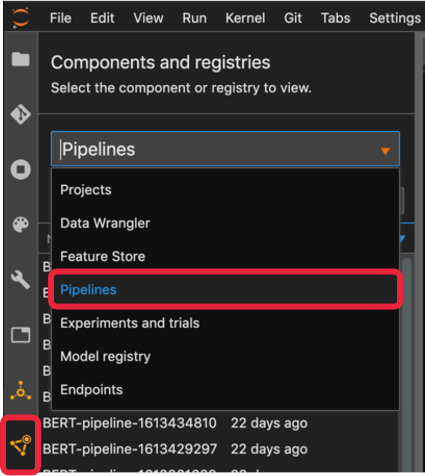